In [1]:
import sys
sys.path.append('..')

In [2]:
import numpy as np
import pandas as pd
import netCDF4 as nc
import matplotlib.pyplot as plt
import utils
import utils_preprocess
import utils_spatial_interpolation
import utils_spatial_analysis

from config import Config
from utils_satellite_imputation import satellite_imputation
from utils_iterative_refinement import iterative_refinement

# Step 0: Load shapefile

In [ ]:
# Load the shapefile
path_shape = Config.shapefile_path
aquifer_shape = utils.load_shapefile(path=path_shape)

# STEP 1: Preprocessing PDSI and GLDAS data into Tabular Format

In [ ]:
# Process the pdsi netcdf files to obtain tabular data pickle file
pdsi_source_directory = Config.pdsi_source_directory
pdsi_target_directory = Config.pdsi_target_directory

utils_preprocess.process_pdsi_data(
    source_directory=pdsi_source_directory, 
    target_directory=pdsi_target_directory,
    date_start=Config.pdsi_preprocessing_start,
    date_end=Config.pdsi_preprocessing_end,
    )

In [ ]:
# Process the gldas netcdf files to obtain tabular data pickle file
gldas_source_directory = Config.gldas_source_directory
gldas_target_directory = Config.gldas_target_directory

utils_preprocess.process_gldas_data(
    source_directory=gldas_source_directory,
    target_directory=gldas_target_directory,
)

# Step 2: Transform PDSI, GLDAS, and Well Observations into format for ML

### Process PDSI

In [ ]:
# Parse pdsi data and save it
directory_pdsi = Config.pdsi_target_directory

pdsi:dict = utils.pull_relevant_data(
    shape=aquifer_shape, 
    dataset_name=Config.pdsi_dataset_name,
    dataset_directory=directory_pdsi
    )

utils.save_pickle(
    data=pdsi, 
    file_name=Config.pdsi_file_name,
    directory=Config.dataset_directory,
    protocol=3)

### Process GLDAS

In [ ]:
# Parse the GLDAS data and save it
directory_gldas = Config.gldas_target_directory

gldas:dict = utils.pull_relevant_data(
    shape=aquifer_shape, 
    dataset_name=Config.gldas_dataset_name,
    dataset_directory=directory_gldas
    )

utils.save_pickle(
    data=gldas, 
    file_name=Config.gldas_file_name,
    directory=Config.dataset_directory,
    protocol=3)

### Process Well Observations

In [ ]:
# Process well data from csv files
well_locations = pd.read_csv(Config.well_locations_path)
well_timeseries = pd.read_csv(Config.well_timeseries_path)

data: dict = utils.transform_well_data(
    well_timeseries=well_timeseries,
    well_locations=well_locations,
    timeseries_name=Config.well_data_timeseries_name,
    locations_name=Config.well_data_locations_name,
    std_threshold=Config.well_max_std,
    min_monthly_obs=Config.well_min_observations,
    gap_size=Config.well_gap_size,
    pad=Config.well_padding,
    start_date=Config.well_processing_start,
    end_date=Config.well_processing_end,
)

utils.save_pickle(
    data=data, 
    file_name=Config.well_data_file_name,
    directory=Config.dataset_directory,
    protocol=3,
    )


In [ ]:
# Plot the timeseries data to see if it looks reasonable
plt.plot(data["timeseries"], '-.')
plt.show()

# Step 3: Develop initial imputation model

In [3]:
satellite_imputation(
    aquifer_name=Config.aquifer_name,
    pdsi_pickle=Config.pdsi_file_name,
    gldas_pickle=Config.gldas_file_name,
    well_data_pickle=Config.well_data_file_name,
    output_file=Config.satellite_imputation_output_file,
    timeseries_name=Config.well_data_timeseries_name,
    locations_name=Config.well_data_locations_name,
    validation_split=Config.validation_split,
    folds=Config.folds,
    batch_size=Config.batch_size,
)

INFO:utils:Pickle file 'pdsi_data.pickle' loaded successfully from 'artifacts/dataset_outputs'
INFO:utils:Pickle file 'gldas_data.pickle' loaded successfully from 'artifacts/dataset_outputs'
INFO:utils:Pickle file 'beryl_enterprise_data.pickle' loaded successfully from 'artifacts/dataset_outputs'
  0%|          | 0/57 [00:00<?, ?it/s]INFO:root:Starting imputation for well: 373338113431502
INFO:root:Starting k-fold cross validation for well: 373338113431502
INFO:root:Finished k-fold cross validation for well: 373338113431502
INFO:root:Starting model training for well: 373338113431502
INFO:root:number of epochs: [64, 23, 48, 18, 19]
INFO:root:Finished model training for well: 373338113431502
  2%|▏         | 1/57 [00:05<05:15,  5.63s/it]INFO:root:Starting imputation for well: 373418113430601
INFO:root:Starting k-fold cross validation for well: 373418113430601
INFO:root:Finished k-fold cross validation for well: 373418113430601
INFO:root:Starting model training for well: 373418113430601
I

<Axes: >

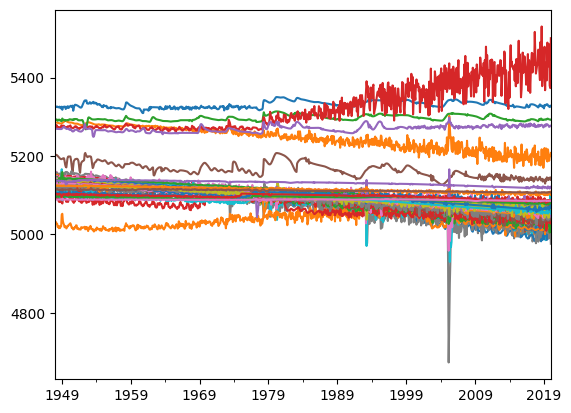

In [4]:
import pickle

data = pickle.load(open(
    "/home/saul/workspace/groundwater_well_imputation/groundwater_imputation/src/imputation_api/artifacts/dataset_outputs/beryl_enterprise_imputation_satellite.pickle", 
    "rb",))
data["Data"].plot(legend=False)

In [ ]:
import pickle

data = pickle.load(open(
    "/home/saul/workspace/groundwater_well_imputation/groundwater_imputation/src/imputation_api/sample_artifacts/dataset_outputs/beryl_enterprise_imputation_satellite.pickle", 
    "rb",))
data["Data"].plot(legend=False)

# Step 4: Develop iterative refinement model

In [ ]:
iterative_refinement(
    aquifer_name=Config.aquifer_name,
    imputed_data_pickle=Config.satellite_imputation_output_file,
    output_file=Config.iterative_imputation_output_file,
    validation_split=Config.validation_split,
    folds=Config.folds,
    feature_threshold=Config.feature_threshold,
    n_iterations=Config.n_iterations_refinement,
    batch_size=Config.batch_size,
)

# Step 5: Analyze spatial characteristics of imputation model

In [ ]:
utils_spatial_interpolation.kriging_interpolation(
    data_pickle_path=(Config.dataset_directory
    + "/" + Config.spatial_input_file),
    shape_file_path=Config.shapefile_path,
    n_x_cells=Config.number_of_x_cells,
    influence_distance=Config.influence_distance,
    monthly_time_step=Config.monthly_time_step,
    netcdf_filename=Config.raster_file_name,
    directory=Config.dataset_directory,
)

# Step 6: Calculate Storage Change

In [ ]:
raster = nc.Dataset(
        Config.dataset_directory + "/" + Config.raster_file_name,
        "r",
    )

spatial_analysis = utils_spatial_analysis.StorageChangeCalculator(
    units=Config.units,
    storage_coefficient=Config.storage_coefficient,
    anisotropic=Config.anisotropic,
    )

storage_change = spatial_analysis.calulate_storage_curve(
    raster=raster, 
    date_range_filter=(Config.date_filter_start, Config.date_filter_end), # if you need to filter dates within of original time range
    dataset_directory=Config.dataset_directory,
    filename=Config.storage_change_file_name,
    )

plt.plot(storage_change, '-.')